# Derivatives

## Objectives

1. Calculate AUDPC (area under the disease progress curve) for each panel at each time point (downy mildew only) using the full scout record.

2. Calculate derivatives of the EVI vs. day-of-year time series for each panel.

3. Examine correlation between EVI derivative and AUDPC

## 1. AUDPC, full scout record

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from scipy import integrate
from matplotlib import pyplot as plt


In [2]:
# read in scout data for each year separately

scout_2020 = pd.read_csv('../data/scout/scout_2020_gdf.csv')
scout_2021 = pd.read_csv('../data/scout/scout_2021_gdf.csv')
scout_2022 = pd.read_csv('../data/scout/scout_2022_gdf.csv')

In [3]:
scout_2020.head()

,Date,Row,Panel,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid
0,2020-06-18,1,1,5.0,PM,0.0,0.00,0.00,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145)
1,2020-06-18,1,2,9.0,PM,0.0,0.05,5.05,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654)
2,2020-06-18,1,4,18.0,PM,0.0,0.00,0.50,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055)
3,2020-06-18,1,5,6.0,PM,0.0,0.00,15.10,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546)
4,2020-06-18,1,6,2.0,PM,0.0,0.00,5.65,"POLYGON ((-77.01570014425 42.878381989255075, ...",POINT (-77.01574402030295 42.87839504362453)


In [4]:
# Functionalize

def add_audpc(df, date_col, dis_col):
    
    '''Inputs:
    df (pandas dataframe) - dataframe with dates and disease ratings
    date_col (str) - name of the column containing dates
    dis_col (str) - name of the column containing disease ratings
    '''
    
    #Calculate AUDPC for each date
    x_vals = df[date_col]
    
    y_vals = df[dis_col]
    
    # for more on trapezoidal integration, 
    # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html
    
    integrals = integrate.cumulative_trapezoid(y_vals, x_vals, initial=0)
    
    #Add audpc column to original dataframe
    df[dis_col+'_audpc'] = integrals
    
    #return df

Problem: Calculating AUC with only the above function groups all panels together on each day.
Solution: Group entries by panel geometry and find AUDPC for each panel separately.

In [5]:
# Re-functionalize

def panel_audpc(df, date_col, dis_col):
    
    #Convert date from str to datetime
    as_datetime = pd.to_datetime(df[date_col], infer_datetime_format=True)
    
    #Convert dates to DOY
    day_of_year = np.asarray([d.timetuple().tm_yday for d in as_datetime])
    
    # Subtract first date from all dates to scale the AUDPC calculation
    scaled = np.asarray([d-day_of_year.min() for d in day_of_year])
    
    # Add column for DOY
    df['doy'] = scaled
    
    #group by geometry 
    geometries = df.geometry.unique()
    panel_dfs=[]
    
    for g in geometries:
        panel_df = df[df['geometry']==g]
        panel_dfs.append(panel_df)
    
    for p in panel_dfs:
        add_audpc(p, 'doy', dis_col)
    
    #recombine the dataframes
    
    recomb = pd.concat(panel_dfs).sort_values(by=['Date', 'Row', 'Panel'])
    
    return recomb

In [6]:
audpc_2020 = panel_audpc(scout_2020, 'Date', 'DM_severity')
audpc_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 0 to 1171
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1172 non-null   object 
 1   Row                1172 non-null   int64  
 2   Panel              1172 non-null   int64  
 3   Treatment          1172 non-null   float64
 4   Block              1172 non-null   object 
 5   PM_severity        1172 non-null   float64
 6   DM_severity        1172 non-null   float64
 7   total_dis          1172 non-null   float64
 8   geometry           1172 non-null   object 
 9   centroid           1172 non-null   object 
 10  doy                1172 non-null   int64  
 11  DM_severity_audpc  1172 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 119.0+ KB


/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dis_col+'_audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dis_col+'_audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [7]:
audpc_2020

,Date,Row,Panel,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid,doy,DM_severity_audpc
0,2020-06-18,1,1,5.0,PM,0.0,0.00,0.00,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145),0,0.000
1,2020-06-18,1,2,9.0,PM,0.0,0.05,5.05,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654),0,0.000
2,2020-06-18,1,4,18.0,PM,0.0,0.00,0.50,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055),0,0.000
3,2020-06-18,1,5,6.0,PM,0.0,0.00,15.10,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546),0,0.000
4,2020-06-18,1,6,2.0,PM,0.0,0.00,5.65,"POLYGON ((-77.01570014425 42.878381989255075, ...",POINT (-77.01574402030295 42.87839504362453),0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
1167,2020-09-09,10,12,20.0,DM,0.0,11.75,23.50,POLYGON ((-77.01622795901153 42.87870217016852...,POINT (-77.01626982030344 42.878714948636684),83,315.800
1168,2020-09-09,10,13,8.0,DM,0.0,0.20,0.40,"POLYGON ((-77.0163147390058 42.87871901016951,...",POINT (-77.01635581030357 42.87873143863867),83,13.775
1169,2020-09-09,10,14,32.0,DM,0.0,9.50,19.00,"POLYGON ((-77.0163999390002 42.87873515017044,...",POINT (-77.01644346530357 42.878748438640656),83,236.850
1170,2020-09-09,10,15,2.0,DM,0.0,58.00,100.00,POLYGON ((-77.0164900489943 42.878753010171465...,POINT (-77.01652978530375 42.878765158642686),83,1635.100


In [8]:
audpc_2021 = panel_audpc(scout_2021, 'Date', 'DM_severity')
audpc_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920 entries, 0 to 1919
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1920 non-null   object 
 1   Row                1920 non-null   int64  
 2   Panel              1920 non-null   int64  
 3   Treatment          1920 non-null   float64
 4   Block              1920 non-null   object 
 5   PM_severity        1919 non-null   float64
 6   DM_severity        1915 non-null   float64
 7   total_dis          1920 non-null   float64
 8   geometry           1920 non-null   object 
 9   centroid           1920 non-null   object 
 10  doy                1920 non-null   int64  
 11  DM_severity_audpc  1913 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 195.0+ KB


/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dis_col+'_audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dis_col+'_audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [9]:
audpc_2021.head()

,Date,Row,Panel,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid,doy,DM_severity_audpc
0,2021-06-24,1,1,5.0,DM,0.0,0.0,0.10,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145),0,0.0
1,2021-06-24,1,2,7.0,DM,0.0,0.0,0.20,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654),0,0.0
2,2021-06-24,1,3,9.0,DM,0.0,0.0,0.15,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851),0,0.0
3,2021-06-24,1,4,15.0,DM,0.0,0.0,0.15,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055),0,0.0
4,2021-06-24,1,5,3.0,DM,0.0,0.0,0.15,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546),0,0.0


In [10]:
audpc_2022 = panel_audpc(scout_2022, 'Date', 'DM_severity')
audpc_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1871 entries, 0 to 1870
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1871 non-null   object 
 1   Row                1871 non-null   int64  
 2   Panel              1871 non-null   int64  
 3   Treatment          1871 non-null   int64  
 4   Block              1871 non-null   object 
 5   PM_severity        1679 non-null   float64
 6   DM_severity        1871 non-null   float64
 7   total_dis          1679 non-null   float64
 8   geometry           1871 non-null   object 
 9   centroid           1871 non-null   object 
 10  doy                1871 non-null   int64  
 11  DM_severity_audpc  1871 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 190.0+ KB


/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dis_col+'_audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dis_col+'_audpc'] = integrals
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2826477873.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

# 2. EVI derivatives

In [11]:
# Read in img_scout dfs

img_scout_2020 = pd.read_csv('../data/img_scout_dfs/2020/skysat_scout_2020.csv')
img_scout_2021 = pd.read_csv('../data/img_scout_dfs/2021/skysat_scout_2021.csv')
img_scout_2022 = pd.read_csv('../data/img_scout_dfs/2022/skysat_scout_2022.csv')
img_scout_2020.head()

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid
0,20200625,2,0.055840,0.074537,0.063650,0.284137,1,2,2020-06-25,9.0,PM,0.0,0.0,0.15,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654)
1,20200625,3,0.051873,0.070787,0.058603,0.277567,1,3,2020-06-25,22.0,PM,0.0,0.0,0.10,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851)
2,20200625,4,0.052025,0.073668,0.061257,0.285911,1,4,2020-06-25,18.0,PM,0.0,0.0,0.40,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055)
3,20200625,5,0.047086,0.067566,0.049576,0.312017,1,5,2020-06-25,6.0,PM,0.0,0.0,0.35,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546)
4,20200625,6,0.051490,0.073420,0.058720,0.301683,1,6,2020-06-25,2.0,PM,0.0,0.0,0.00,"POLYGON ((-77.01570014425 42.878381989255075, ...",POINT (-77.01574402030295 42.87839504362453)


In [12]:
# Merge dfs to add audpc and DOY columns to the image data
merged_2020 = pd.merge(img_scout_2020, audpc_2020)
merged_2021 = pd.merge(img_scout_2021, audpc_2021)
merged_2022 = pd.merge(img_scout_2022, audpc_2022)


In [13]:
merged_2022.head()

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,Block,PM_severity,DM_severity,total_dis,geometry,centroid,Row,Panel,doy,DM_severity_audpc
0,20220622,1,0.058377,0.084667,0.086377,0.367607,1,1,2022-06-22,26.0,PM,0.0,0.0,0.75,POLYGON ((-77.0152645742787 42.878300949250196...,POINT (-77.0153084903025 42.8783140936145),1,1,0,0.0
1,20220622,2,0.058603,0.085176,0.088338,0.357583,1,2,2022-06-22,17.0,PM,0.0,0.0,1.05,POLYGON ((-77.01535545427274 42.87831851925121...,POINT (-77.0153965503027 42.87833067861654),1,2,0,0.0
2,20220622,3,0.059032,0.086039,0.087004,0.360371,1,3,2022-06-22,31.0,PM,0.0,0.0,0.50,POLYGON ((-77.01544069426711 42.87833411925217...,POINT (-77.01548247530272 42.87834674861851),1,3,0,0.0
3,20220622,4,0.057917,0.086170,0.088193,0.365127,1,4,2022-06-22,3.0,PM,0.0,0.0,0.95,POLYGON ((-77.01552730426143 42.87835065925314...,POINT (-77.01557007030289 42.87836309362055),1,4,0,0.0
4,20220622,5,0.059172,0.085890,0.089700,0.359786,1,5,2022-06-22,27.0,PM,0.0,0.0,0.80,POLYGON ((-77.01561588425558 42.87836680925413...,POINT (-77.01565649030296 42.878378758622546),1,5,0,0.0


In [14]:
def add_vis(df):
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    df['sr']= df['nir']/df['red']
    df['msr']= ((df['nir']/df['red'])-1)/(np.sqrt((df['nir']/df['red'])+1))
    #df['dvi']= df['nir']-df['red']
    #df['nirv']= df['ndvi']*df['nir']
    df['gcc']=df['green']/(df['green']+df['red']+df['blue'])
    #df['tvi']=0.5*(120*(df['nir']-df['green'])-200*(df['red']-df['green']))
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    
    return df

In [15]:
vis_2020 = add_vis(merged_2020)
vis_2021 = add_vis(merged_2021)
vis_2022 = add_vis(merged_2022)

In [16]:
# Test with just one panel from 2021 dataset

#group panels by geometry 
geometries = vis_2021.geometry.unique()
panel_dfs=[]
    
for g in geometries:
    panel_df = vis_2021[vis_2021['geometry']==g]
    panel_dfs.append(panel_df)

len(panel_dfs)

240

In [17]:
# Check one of the panel dfs - there should be 5 entries, one for each imag/scout day
panel_dfs[0]

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,...,Panel,doy,DM_severity_audpc,ndvi,evi,savi,sr,msr,gcc,arvi
0,20210707,1,0.032006,0.066432,0.040084,0.290003,1,1,2021-07-07,5.0,...,1,13,0.000,0.757132,0.484168,0.451614,7.234911,2.172705,0.479577,0.715161
240,20210726,1,0.041110,0.079731,0.059255,0.374331,1,1,2021-07-27,5.0,...,1,33,0.000,0.726674,0.554112,0.506235,6.317272,1.965687,0.442713,0.657318
480,20210802,1,0.006183,0.034373,0.028510,0.247497,1,1,2021-08-03,5.0,...,1,40,4.375,0.793411,0.398975,0.423295,8.681048,2.468649,0.497683,0.659196
719,20210809,1,0.015450,0.047587,0.035944,0.296291,1,1,2021-08-10,5.0,...,1,47,11.200,0.783624,0.466211,0.469243,8.243175,2.382420,0.480773,0.679994
959,20210816,1,0.019269,0.072103,0.049700,0.285644,1,1,2021-08-17,5.0,...,1,54,16.800,0.703588,0.409816,0.423677,5.747359,1.827617,0.511109,0.561855


In [18]:
test_panel = panel_dfs[0]

f= test_panel['evi']
x= test_panel['doy']

derivs = np.gradient(f, x)
derivs

array([ 0.00349722, -0.01550992, -0.00627865,  0.00077432, -0.00805648])

<AxesSubplot: xlabel='doy'>

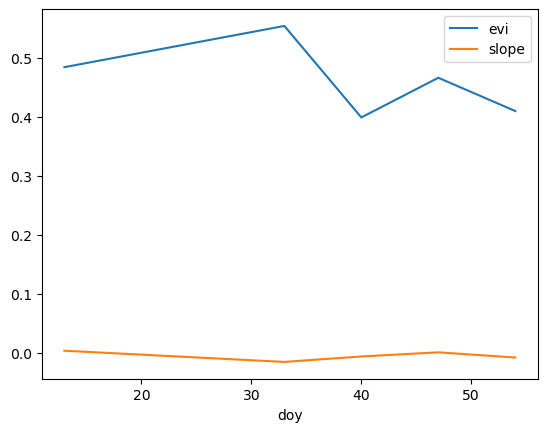

In [19]:
slope = pd.Series(derivs, x, name='slope')
evi = pd.Series(f.values, x, name='evi')
df = pd.concat([evi, slope], axis=1)
df.plot()

In [26]:
# Add derivatives for evi to all panels in 2021

def add_derivs(df, f_col, x_col):
    
    #group panels by geometry 
    geometries = df.geometry.unique()
    panel_dfs=[]
    
    for g in geometries:
        panel_df = df[df['geometry']==g]
        panel_dfs.append(panel_df)
        
    for p in panel_dfs:
        f= p[f_col]
        x= p[x_col]
        
        derivs = np.gradient(f, x)
        p['deriv_'+ f_col] = derivs
    
    recomb = pd.concat(panel_dfs).sort_values(by=['Date', 'Row', 'Panel'])
    
    return recomb

In [27]:
derivs_2021 = add_derivs(vis_2021, 'evi', 'doy')

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/3955083256.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['deriv_'+ f_col] = derivs
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/3955083256.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['deriv_'+ f_col] = derivs
/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/3955083256.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [28]:
derivs_2021

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,...,doy,DM_severity_audpc,ndvi,evi,savi,sr,msr,gcc,arvi,deriv_evi
0,20210707,1,0.032006,0.066432,0.040084,0.290003,1,1,2021-07-07,5.0,...,13,0.0000,0.757132,0.484168,0.451614,7.234911,2.172705,0.479577,0.715161,0.003497
1,20210707,2,0.033528,0.067879,0.043324,0.270290,1,2,2021-07-07,7.0,...,13,0.0000,0.723710,0.443716,0.418440,6.238777,1.947141,0.469003,0.671497,0.003376
2,20210707,3,0.033903,0.067897,0.042947,0.273817,1,3,2021-07-07,9.0,...,13,0.0000,0.728841,0.451899,0.423997,6.375737,1.979408,0.469072,0.680854,0.003742
3,20210707,4,0.032868,0.067358,0.042055,0.280455,1,4,2021-07-07,15.0,...,13,0.0000,0.739203,0.463353,0.434767,6.668789,2.047043,0.473417,0.691031,0.003757
4,20210707,5,0.032104,0.066636,0.038836,0.292664,1,5,2021-07-07,3.0,...,13,0.0000,0.765697,0.493868,0.457899,7.535957,2.237088,0.484359,0.730553,0.003602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,20210816,303,0.017663,0.065519,0.048503,0.248441,19,15,2021-08-17,18.0,...,54,71.9125,0.673318,0.355257,0.376320,5.122157,1.665990,0.497544,0.515878,-0.010269
1191,20210816,305,0.009077,0.061277,0.038242,0.256381,20,1,2021-08-17,31.0,...,54,4.2500,0.740401,0.384656,0.411778,6.704175,2.055085,0.564266,0.583637,-0.008889
1192,20210816,307,0.009167,0.060350,0.038300,0.249923,20,3,2021-08-17,40.0,...,54,5.6500,0.734234,0.374960,0.402722,6.525413,2.014186,0.559746,0.575031,-0.009591
1193,20210816,309,0.011672,0.062224,0.041776,0.253272,20,5,2021-08-17,14.0,...,54,5.2500,0.716820,0.373304,0.399026,6.062650,1.904996,0.537934,0.557872,-0.010704


In [41]:
# Check to see if derivatives are sig. diff for high disease panels vs. low disease panels

# Group panels by AUDPC

# Find median AUDPC

audpc_median = derivs_2021['DM_severity_audpc'].median()

In [42]:
audpc_median

8.500000000000002

In [45]:
# Find 75th quantile AUPDC

audpc_75 = derivs_2021['DM_severity_audpc'].quantile(0.75)

In [46]:
audpc_75

30.25

In [47]:
over_75 = derivs_2021[derivs_2021['DM_severity_audpc']>=audpc_75]
under_75 = derivs_2021[derivs_2021['DM_severity_audpc']<audpc_75]

In [48]:
over_75.size

8372

In [50]:
under_75.size

25032

<AxesSubplot: xlabel='doy', ylabel='deriv_evi'>

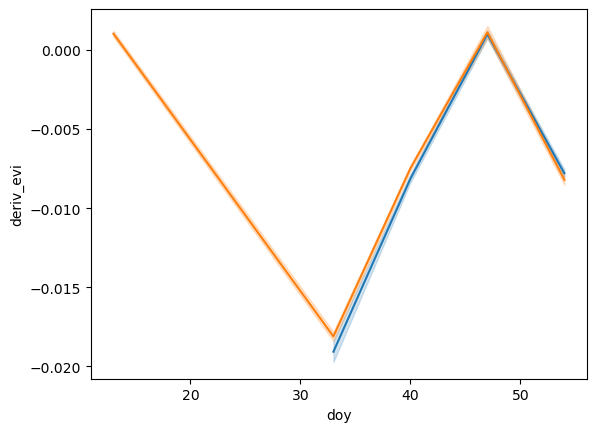

In [52]:
# Plot EVI derivatives
sns.lineplot(data=over_75, x='doy', y='deriv_evi')
sns.lineplot(data=under_75, x='doy', y='deriv_evi')

In [53]:
# Check for sig. differences in derivatives

from scipy import stats
def mann_whitney_u_test(distribution_1, distribution_2):
    """
    Perform the Mann-Whitney U Test, comparing two different distributions.
    Args:
       distribution_1: List. 
       distribution_2: List.
    Outputs:
        u_statistic: Float. U statisitic for the test.
        p_value: Float.
    """
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
    return print("Mann-Whitney U:", u_statistic, "p-value:", p_value)



In [55]:
mann_whitney_u_test(over_75['deriv_evi'], under_75['deriv_evi'])

Mann-Whitney U: 126904.0 p-value: 0.19068576868918863


In [56]:
# Confirm EVI values are sig. diff.
mann_whitney_u_test(over_75['evi'], under_75['evi'])

Mann-Whitney U: 86832.0 p-value: 1.0995347267966592e-19


In [66]:
# Plot spectra of high dis. vs. low dis.
melted = pd.melt(derivs_2021, id_vars=['Date','geometry', 'DM_severity_audpc'], 
                 value_vars=['blue', 'green','red','nir'],
                var_name = 'wavelength',
                value_name = 'reflectance')

In [67]:
melted

,Date,geometry,DM_severity_audpc,wavelength,reflectance
0,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0000,blue,0.032006
1,2021-07-07,POLYGON ((-77.01535545427274 42.87831851925121...,0.0000,blue,0.033528
2,2021-07-07,POLYGON ((-77.01544069426711 42.87833411925217...,0.0000,blue,0.033903
3,2021-07-07,POLYGON ((-77.01552730426143 42.87835065925314...,0.0000,blue,0.032868
4,2021-07-07,POLYGON ((-77.01561588425558 42.87836680925413...,0.0000,blue,0.032104
...,...,...,...,...,...
4775,2021-08-17,POLYGON ((-77.01536426393243 42.87876078918534...,71.9125,nir,0.248441
4776,2021-08-17,POLYGON ((-77.01658187329902 42.87901510909438...,4.2500,nir,0.256381
4777,2021-08-17,POLYGON ((-77.0164079733105 42.878982759092416...,5.6500,nir,0.249923
4778,2021-08-17,POLYGON ((-77.01623108332213 42.87894828909042...,5.2500,nir,0.253272


In [83]:
melted['disease_sev'] = 'high'
melted.loc[melted['DM_severity_audpc'] < audpc_75, 'disease_sev'] = 'low'

In [84]:
melted.disease_sev.unique()

array(['low', 'high'], dtype=object)

<AxesSubplot: xlabel='wavelength', ylabel='reflectance'>

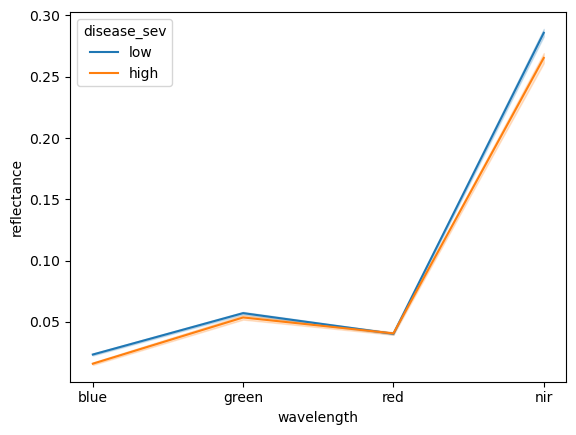

In [87]:
sns.lineplot(data=melted, x='wavelength',y='reflectance', hue='disease_sev')

In [98]:
#replace string labels with center wavelengths

melted_num = melted.replace({'blue': 485, 'green': 555, 'red':650, 'nir':820})


In [100]:
melted_num.head()

,Date,geometry,DM_severity_audpc,wavelength,reflectance,disease_sev
0,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,485,0.032006,low
1,2021-07-07,POLYGON ((-77.01535545427274 42.87831851925121...,0.0,485,0.033528,low
2,2021-07-07,POLYGON ((-77.01544069426711 42.87833411925217...,0.0,485,0.033903,low
3,2021-07-07,POLYGON ((-77.01552730426143 42.87835065925314...,0.0,485,0.032868,low
4,2021-07-07,POLYGON ((-77.01561588425558 42.87836680925413...,0.0,485,0.032104,low


In [101]:
# group by date
dates = melted_num.Date.unique()
daily_dfs = []

for d in dates:
    df = melted_num[melted_num['Date']==d]
    daily_dfs.append(df)

len(daily_dfs)

5

In [102]:
panel_dfs = []

panels = melted_num.geometry.unique()

for p in panels:
    for df in daily_dfs:
        panel_df = df[df['geometry']==p]
        panel_dfs.append(panel_df)

len(panel_dfs)

1200

In [103]:
panel_dfs[0]

,Date,geometry,DM_severity_audpc,wavelength,reflectance,disease_sev
0,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,485,0.032006,low
1195,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,555,0.066432,low
2390,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,650,0.040084,low
3585,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,820,0.290003,low


In [110]:
derivs_test = np.gradient(panel_dfs[0]['reflectance'], panel_dfs[0]['wavelength'])
panel_dfs[0]['deriv_spec'] = derivs_test
panel_dfs[0]
#recomb = pd.concat(panel_dfs).sort_values(by=['Date', 'Row', 'Panel'])


/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/598143405.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_dfs[0]['deriv_spec'] = derivs_test


,Date,geometry,DM_severity_audpc,wavelength,reflectance,disease_sev,deriv_spec
0,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,485,0.032006,low,0.000492
1195,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,555,0.066432,low,0.000165
2390,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,650,0.040084,low,0.000349
3585,2021-07-07,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,820,0.290003,low,0.001470


In [119]:
derivs_test = np.gradient(panel_dfs[1]['reflectance'], panel_dfs[1]['wavelength'])
panel_dfs[1]['deriv_spec'] = derivs_test
panel_dfs[1]

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/2704627340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_dfs[1]['deriv_spec'] = derivs_test


,Date,geometry,DM_severity_audpc,wavelength,reflectance,disease_sev,deriv_spec
240,2021-07-27,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,485,0.041110,low,0.000552
1435,2021-07-27,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,555,0.079731,low,0.000226
2630,2021-07-27,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,650,0.059255,low,0.000526
3825,2021-07-27,POLYGON ((-77.0152645742787 42.878300949250196...,0.0,820,0.374331,low,0.001853


<AxesSubplot: xlabel='wavelength', ylabel='deriv_spec'>

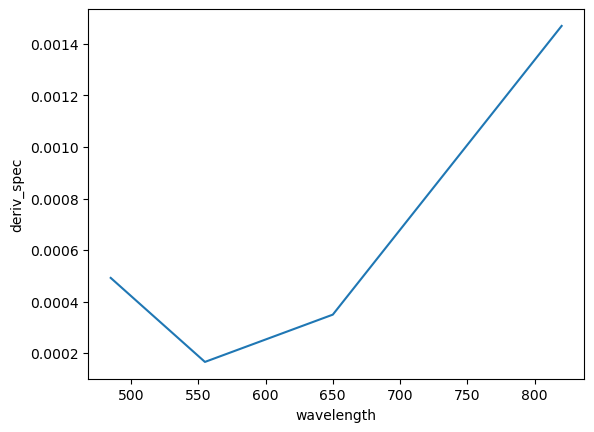

In [113]:
sns.lineplot(x=panel_dfs[0]['wavelength'], y=panel_dfs[0]['deriv_spec'])
#sns.lineplot(x=panel_dfs[0]['wavelength'], y=panel_dfs[0]['reflectance'])

In [117]:
indices = np.arange(len(panel_dfs))

In [118]:
# get derivatives for all lines in panel_dfs
# recombine the panel_dfs in to one

#for p in panel_dfs:
for i in indices:
    derivs = np.gradient(panel_dfs[i]['reflectance'], panel_dfs[i]['wavelength'])
    panel_dfs[i]['deriv_spec'] = derivs

all_panels = pd.concat(panel_dfs).sort_values(by=['Date', 'geometry'])
all_panels.head()

/var/folders/hg/02pmwyy14wvgdv7n1gzwlx1w0000gn/T/ipykernel_3519/3350882116.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_dfs[i]['deriv_spec'] = derivs


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
low_dis = melted_num[melted_num['disease_sev']=='low']
high_dis = melted_num[melted_num['disease_sev']=='high']